In [49]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Estrid Buhl Naver, Maja Østergaard and Silvio Achilles (DTU)
#   Edited by: Margaret Duff (STFC - UKRI)

# Offset reconstruction 

### Reconstruction of an apple measured with offset detector.

Apple measured with lab-Xray CT machine where the detector was offset in order to image the entire sample in the tomography.  We scanned the apple, which was too wide for the regular beam, in offset mode, where the fan only covers a bit more than half of the apple width, and due to offsetting the rotation centre to the side, the other half of the apple will rotate into the fan and as such full data will be recorded.   The default reconstruction done by the table top CT machine did not support this, so we used CIL to set up the offset geometry. This notebook showcases three different reconstructions of this sample, one using the filtered-back-projection and two using iterative methods.

### CIL Version 23.1.0

In [50]:
import cil
print(cil.__version__)

23.1.0


In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt

from cil.io import TIFFStackReader
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, Slicer, Padder
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show_geometry
from cil.framework import AcquisitionGeometry, ImageGeometry
from cil.utilities.jupyter import islicer

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA
from cil.optimisation.functions import IndicatorBox,  LeastSquares, TotalVariation, OperatorCompositionFunction,L2NormSquared
from cil.optimisation.operators import  GradientOperator
                                       
# Import from CIL ASTRA plugin
from cil.plugins.astra.processors import FBP, AstraBackProjector3D
from cil.plugins.astra.operators import ProjectionOperator

## Setting up the geometry

We define the geometry of the system. 

In [52]:
# Define cone geometry variables
SOD = 355 # mm
SDD = 398 # mm
COR = -100 # number of pixels from the edge of the center
pixel_size = 0.048 # mm
image_pixel_size = 0.096 # mm

angles_arr = np.linspace(0, 2*np.pi, 200)

In [53]:
# create AcquisitionGeometry
ag = AcquisitionGeometry.create_Cone3D(
    source_position=[0.0, -SOD, 0.0],
    detector_position=[0, SDD-SOD, 0.0],
    rotation_axis_direction=[0., 0., 1.0]
)
ag.set_centre_of_rotation(-COR*pixel_size)
ag.set_angles(angles=angles_arr, angle_unit='radian' )
ag.set_panel(num_pixels=[500, 500], pixel_size=pixel_size, origin='top-left') 

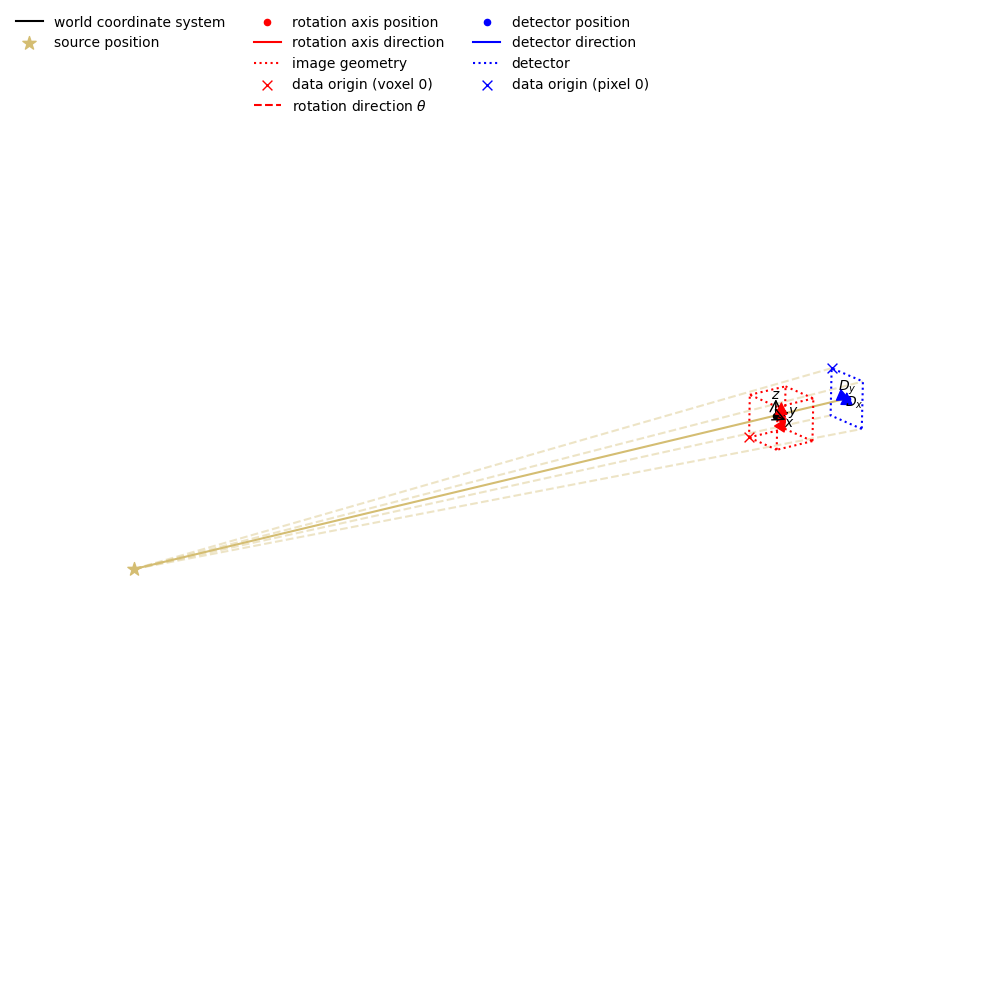

In [54]:
show_geometry(ag, view_distance=2)

## The dataset

This requires the dataset `apple.zip` from [link]
Please download the data and update the 'proj_folder' variable below to point to where you have the projections saved:

In [55]:
proj_folder = './Apple_offset/raw/projections'
n_projs = 200  # and starts with idx 0
data = TIFFStackReader(file_name=proj_folder).read_as_AcquisitionData(ag)

Preprocess the data so it is ready for reconstruction.

In [56]:

data.array = data.array/np.max(data.array)
data = TransmissionAbsorptionConverter()(data)

Visualise the projections: 

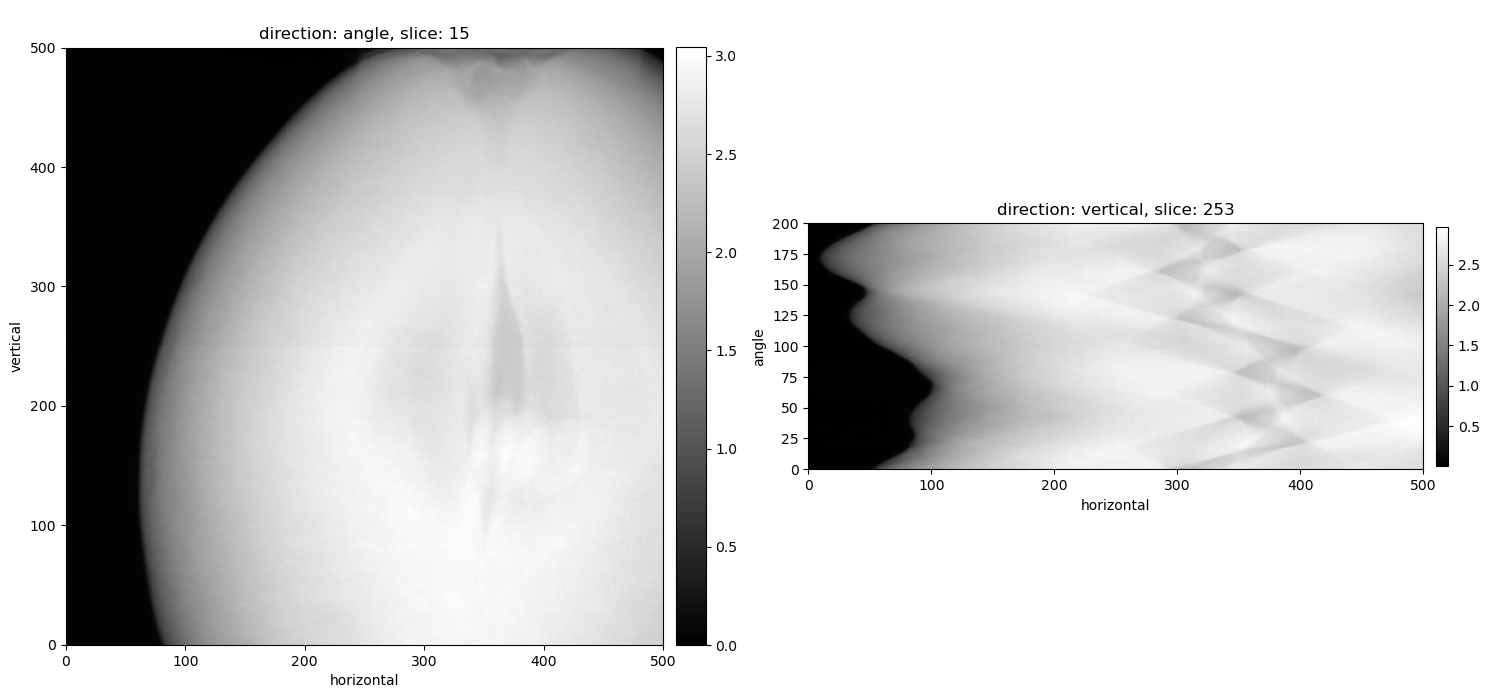

In [57]:
show2D(data, slice_list=[('angle',15), ('vertical', 253) ])


## Automatic reconstruction 

We load the scanner reconstruction for comparison 

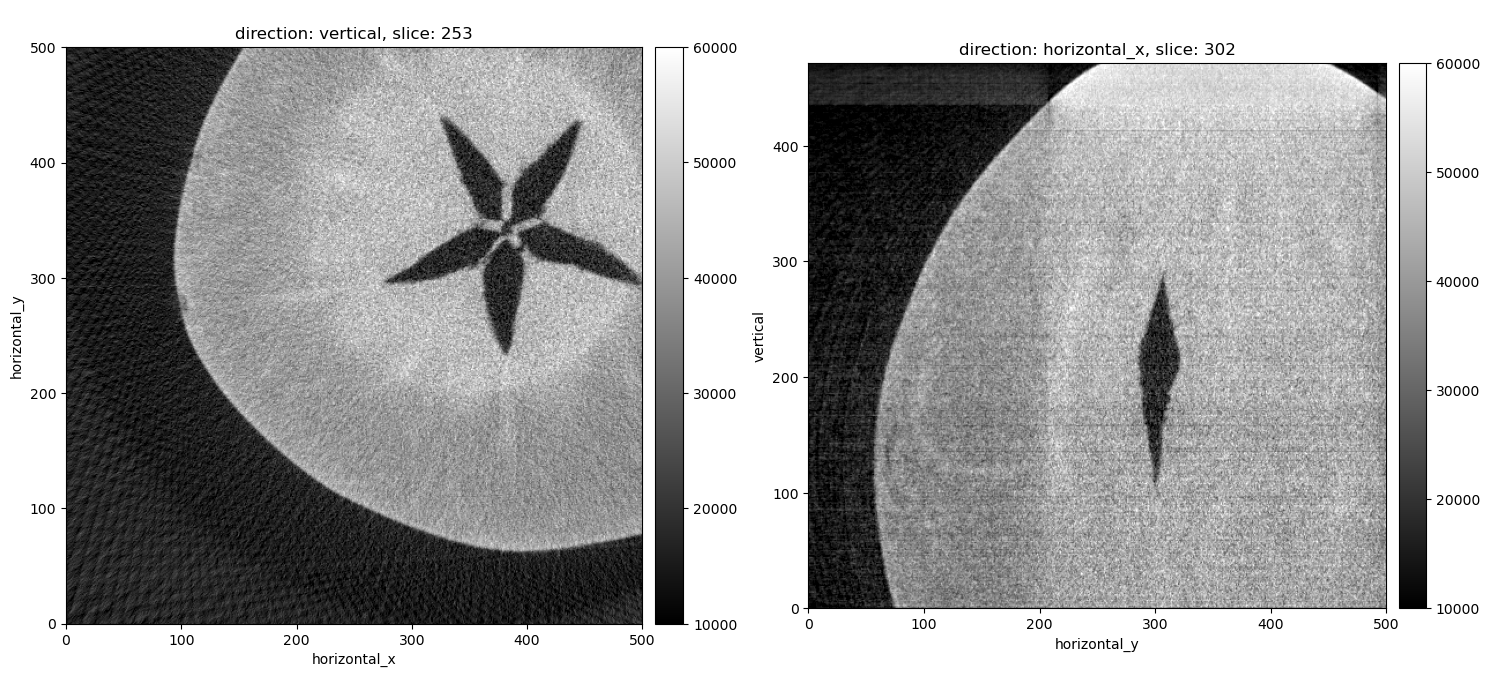

In [58]:
proj_folder = './Apple_offset/raw/reconstruction'
n_projs = 200  # and starts with idx 0
ig = ImageGeometry( 500, 500, 472) 
recon_scanner = TIFFStackReader(file_name=proj_folder).read_as_ImageData(ig )
show2D(recon_scanner, slice_list=[('vertical',253), ('horizontal_x', 302)], fix_range=(10000, 60000))

We see both that the scanner unable to reconstruct the full slice of the apple. There is also a brighter circle as part of the horizontal slice and a brighter vertical strip in the vertical slice.   This is because these areas are always within the field of view whereas the other parts of the apple move in and out the field of view.  The aim of this notebook is to do better! 

## FBP Reconstruction

We start by using the FBP reconstruction. 

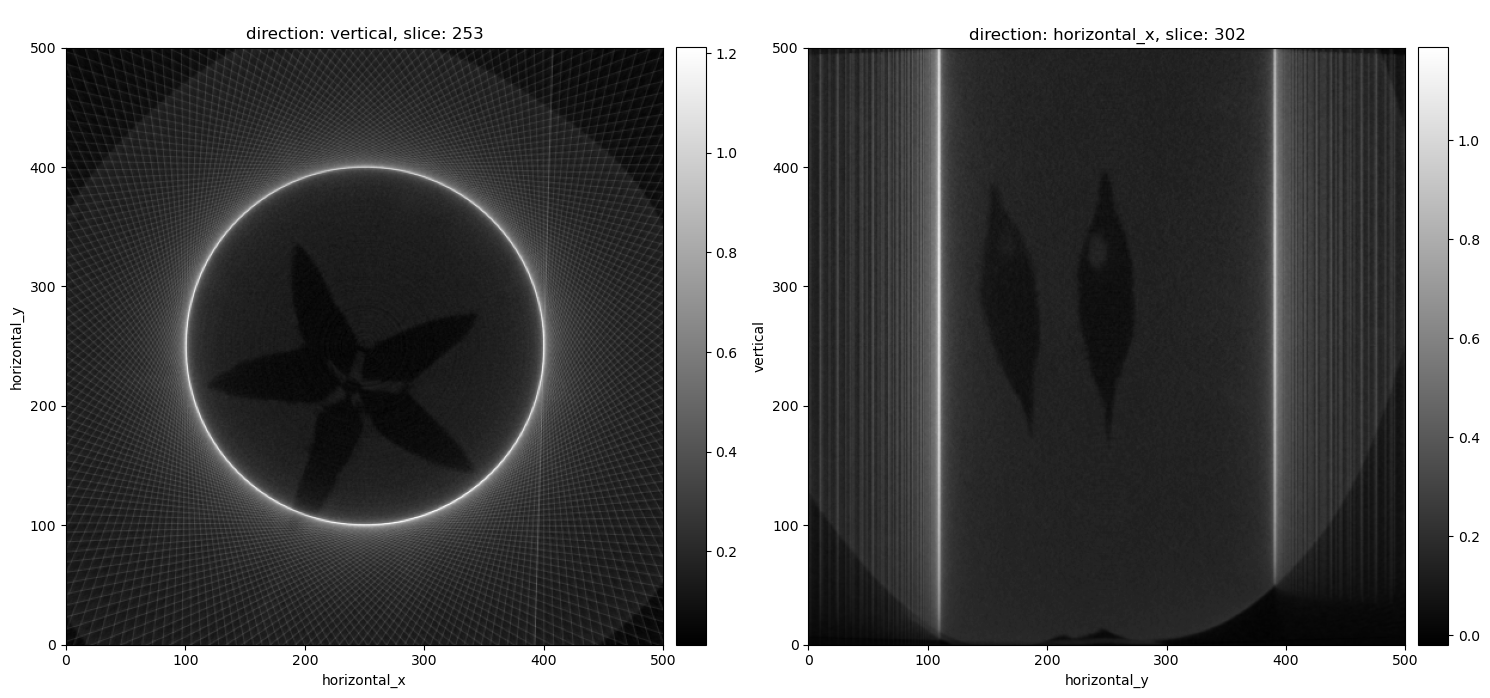

In [59]:
data.reorder(order='astra')
ig = data.geometry.get_ImageGeometry() 
fbp =  FBP(ig, data.geometry, "gpu")
recon = fbp(data)

show2D(recon, slice_list=[('vertical',253), ('horizontal_x', 302)])

There is a very clear region-of-interest artifact so we choose to pad the projections to get it away from the sample.

In [60]:
# Padding the data
Npad = 300
data_padded = Padder.edge(pad_width={'horizontal':(Npad, Npad)})(data) # Padding in horizontal direction

In [61]:
data.reorder(order='astra') # Change the order of the variables in the array

ig = ImageGeometry(580, 580, 400, pixel_size, pixel_size, pixel_size) 


In [62]:
fbp =  FBP(ig, data_padded.geometry, "gpu")
recon = fbp(data_padded)

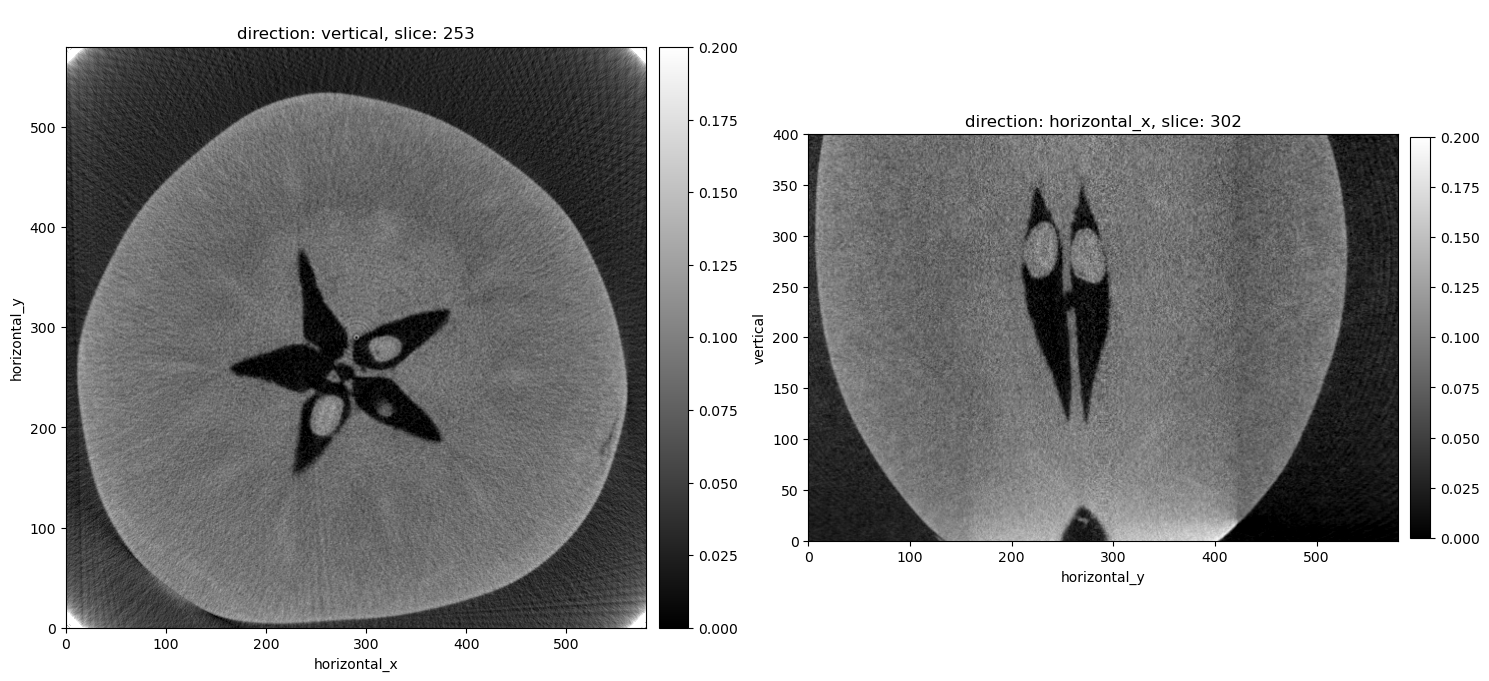

In [63]:
show2D(recon, slice_list=[('vertical',253), ('horizontal_x', 302)], fix_range=(0,0.2))

We can use the CIL centre of rotation corrector to check the centre of rotation inputted when we set up the geometry earlier.

In [64]:
from cil.processors import CentreOfRotationCorrector

processor = CentreOfRotationCorrector.image_sharpness(search_range=100, tolerance=0.1)
processor.set_input(data_padded)
data_centred = processor.get_output()
data_centred.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (0.14603414381488417, 'pixels'), 'angle': (0.0, 'radian')}

We see a very small update of 0.14 pixels on top of the 100 pixels we set earlier. We can update our COR with this value but it makes very little difference to our reconstructed image:

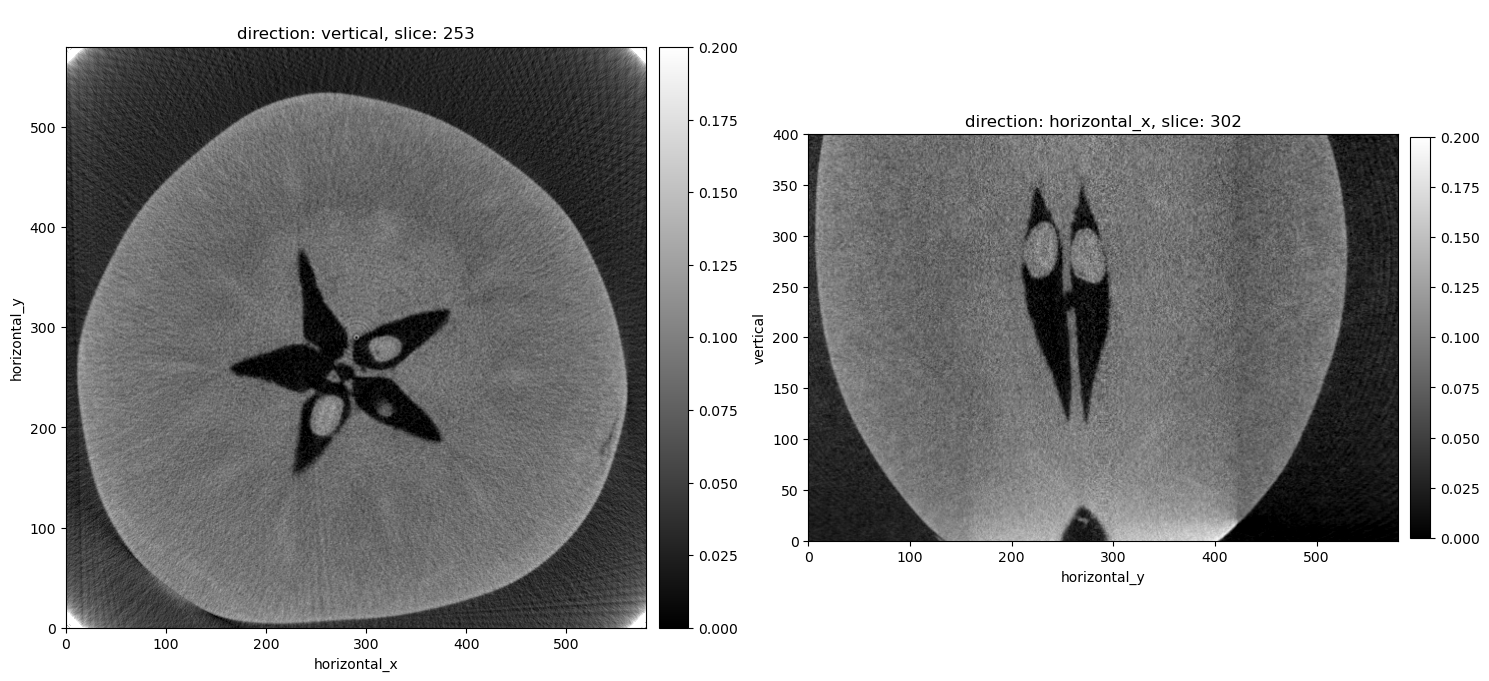

In [65]:
ag.set_centre_of_rotation(-COR*pixel_size+data_centred.geometry.get_centre_of_rotation()['offset'][0]*pixel_size)
fbp =  FBP(ig, data_padded.geometry, "gpu")
recon = fbp(data_padded)
show2D(recon, slice_list=[('vertical',253), ('horizontal_x', 302)], fix_range=(0,0.2))


Showing different slices and adjusting the contrast we can see there still remains a bright circular artifact in the horizontal slice and a stripe pattern in the vertical slice.

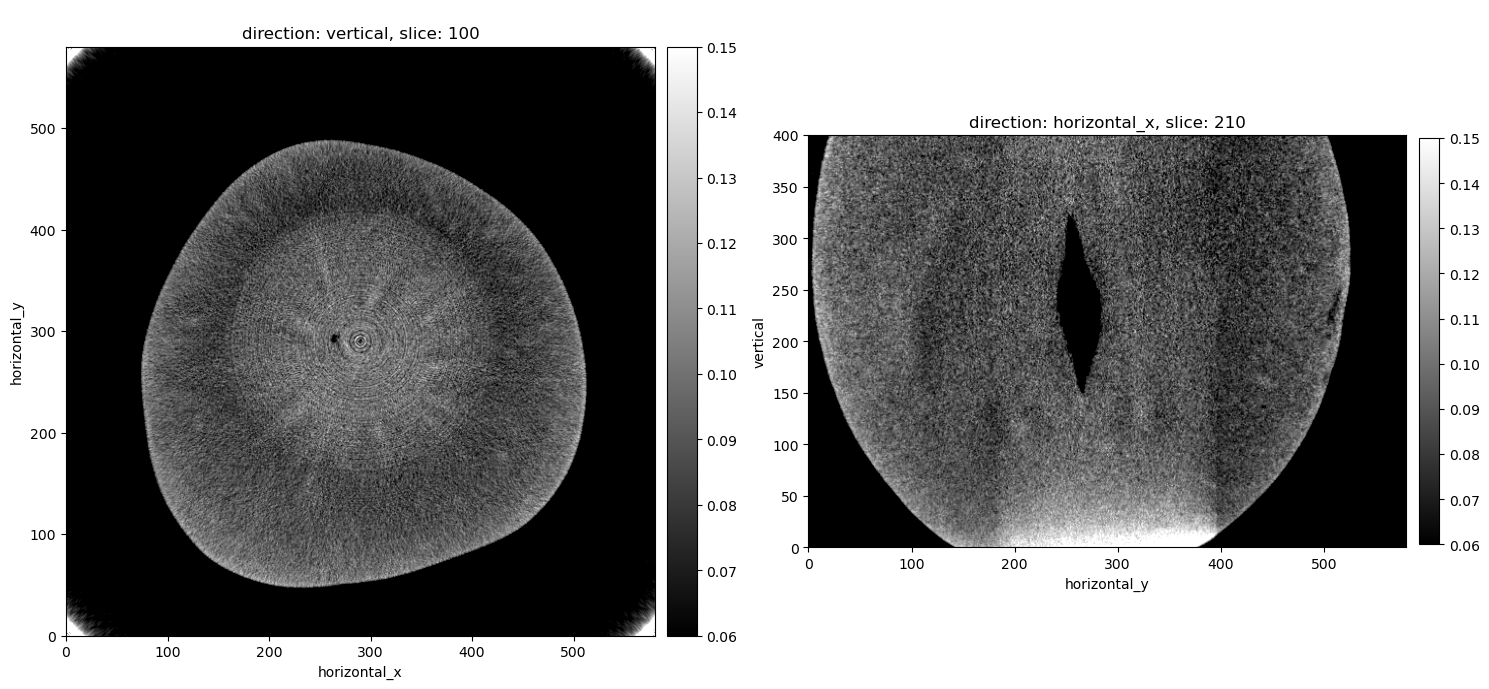

In [66]:
show2D(recon, slice_list=[('vertical',100), ('horizontal_x', 210)], fix_range=(0.06,0.15))

The hope is that using iterative reconstruction, where the projector can take into account the repeated measurements of some areas will lead to a reconstruction without these artifacts. 

## Iterative reconstruction

Reconstruct using the gradient descent algorithm with Tikhonov regularisation. 

In [70]:
data.reorder(order='astra') # Change the order of the variables in the array
ag = data.geometry
#ig = data.geometry.get_ImageGeometry() # save image geometry
ig = data.geometry.get_ImageGeometry() 
# Set up linear operator representing forward and backward projections
A = ProjectionOperator(ig, ag, device="gpu")

In [71]:
f1 = LeastSquares(A, data)# Set up least squares problem
D = GradientOperator(ig)
f2 = OperatorCompositionFunction(L2NormSquared(),D)
alpha=0.5
f = f1 + (alpha**2)*f2

x0 = ig.allocate(0.0) # Start from image no. 0

# Set up gradient descent algorithm
myGD_LS = GD(initial=x0, 
             objective_function=f, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=20)

In [76]:
myGD_LS.run(100, verbose=1) # run gradient descent algorithm

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10       1000        10.467                     


       20       1000         8.206          5.45052e+06
       40       1000         7.039          4.51487e+06
       60       1000         6.637          4.07359e+06


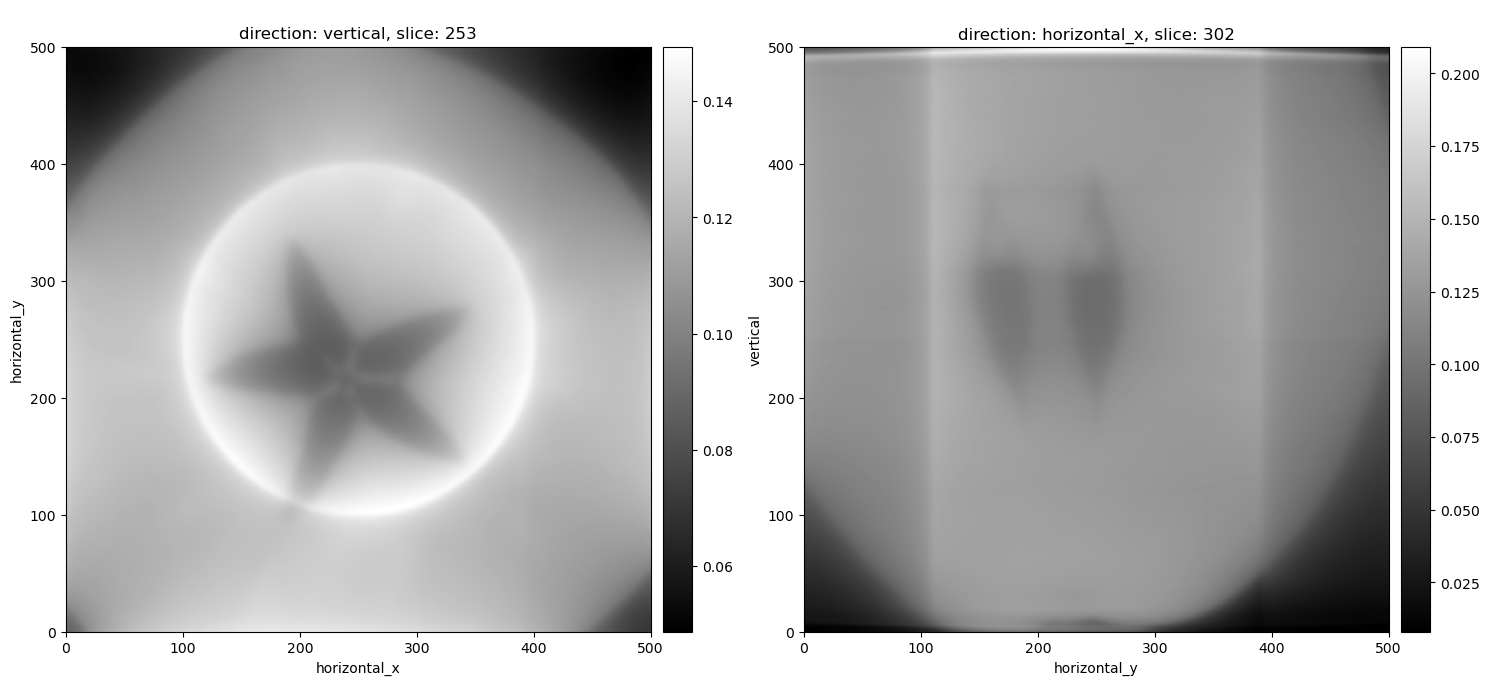

In [73]:
show2D(myGD_LS.solution, slice_list=[('vertical',253), ('horizontal_x', 302)])

## FISTA algorithm with TV 

Reconstruct using the FISTA algorithm with TV regularisation

In [74]:
alpha=0.01
f1 = LeastSquares(A, data) # Set up least squares problem
TV = alpha*TotalVariation( lower=0)
x0 = ig.allocate(0.0)

# Set up FISTA algorithm
myFISTANN = FISTA(
    f=f1,
    g=TV,
    initial=x0,
    max_iteration=100,
    update_objective_interval=10
)

In [75]:
myFISTANN.run(100, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          2.43601e+08


KeyboardInterrupt: 

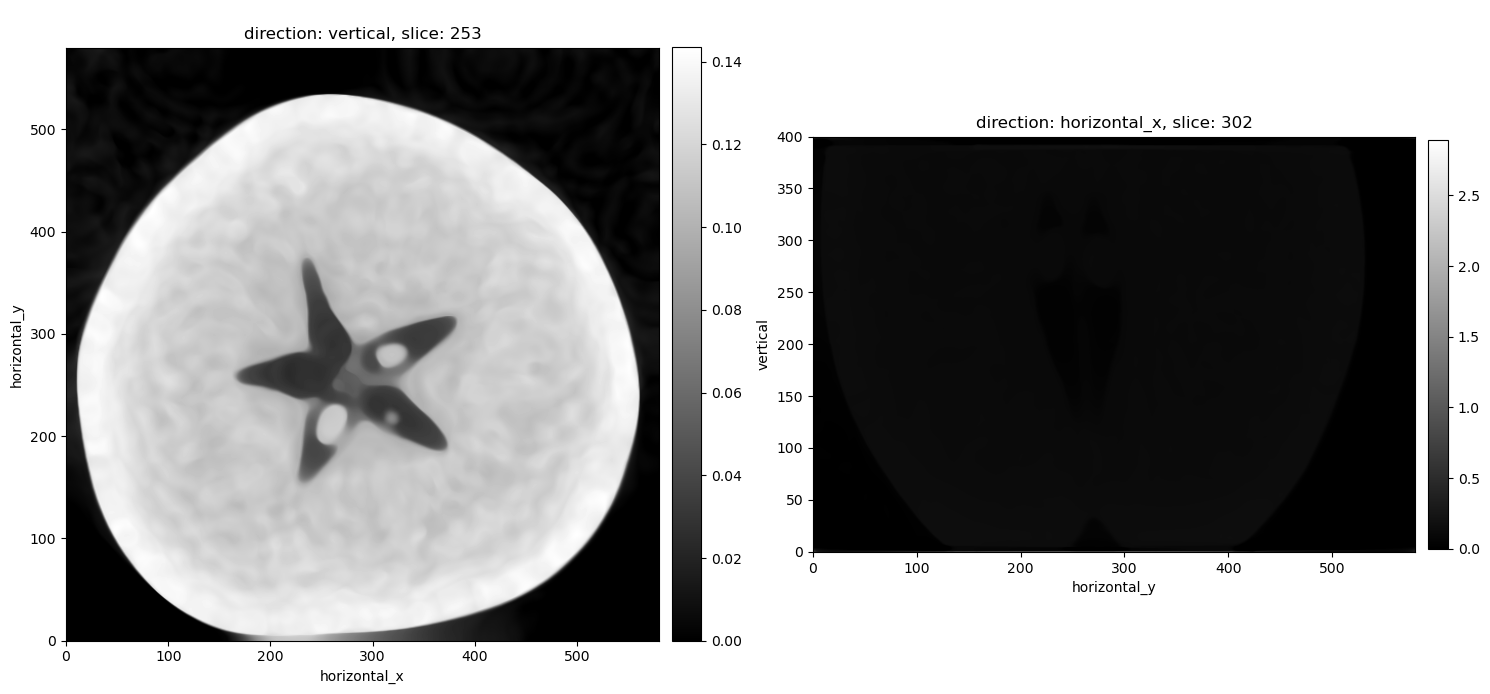

In [ ]:
show2D(myFISTANN.solution, slice_list=[('vertical',253), ('horizontal_x', 302)])